In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
import matplotlib.pyplot as plt
import math

#Umap
import matplotlib.pyplot as plt
from umap import UMAP
import umap

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

#Wordclouds
from wordcloud import WordCloud
from PIL import Image, ImageDraw

from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate

# Data

In [2]:
# Import

path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)

# Export 

columns_export =['id', 'lang', 'title', 'year', 'embedding_x', 'embedding_y', 'cluster', 'subject_list']

path_out = '../BHVizApp/src/data/mapping_out_sample.csv'

In [3]:
df = df.sample(10000)
df = df.fillna('')

## Word Tokenization

In [4]:
text_cols = ['text', 'text_3', 'text_2', 'text_1']
df['subject_list'] = df[text_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)

vectorizer = CountVectorizer(min_df=5)
subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

# tfidf = TfidfVectorizer()
# subject_doc_matrix = tfidf.fit_transform(df.subject_list)

In [5]:
df

bvb                                              title  \
189595  BV037718830  Discorso sulle illustrazioni dell'Esopo di Nap...   
18780   BV005348674  Die Baudenkmäler der deutschen Kolonisation in...   
19266   BV037780628  La Chiesa dei SS. Luca e Martina nell'opera di...   
52787   BV037804265                                  South to Sardinia   
4859    BV010271851                           Old Testament miniatures   
...             ...                                                ...   
127162  BV048446930                                Hollandia Comitatus   
118130  BV047228613                               Architetture al cubo   
138991  BV037662510                                          Ceramiche   
82583   BV038957686  Trattati d'arte del Cinquecento fra manierismo...   
208806  BV043435827         Filippo Parodi, 1630-1702, Genoa's Bernini   

               signature inventory_nr  inventory_date inventory_year lang  \
189595       Br 425-5480                            0                 ita   
18780       Ne 1062-5380                            0                       
19266   Ca-COR 1910-5690                            0                 ita   
52787      Fa 300-5540/a                            0                 eng   
4859      Qe 850-5690 gr                            0                 eng   
...                  ...          ...             ...            ...  ...   
127162      Ro 1440-6000    2001.1313        20010329         2001.0        
118130       Bb 232-6180    2021.1963        20210417         2021.0  ita   
138991      Bs 5027-6070     2009.293        20090126         2009.0  ita   
82583      Gd 403-5600/1     1960.108        20110618         1960.0        
208806   Ca-PAR 630-6160    2016.4557        20160926         2016.0  eng   

        year          sys                                               text  \
189595  1948       Br 425  Anfänge_des_Holz-_und_Metallschnitts_(15._Jh.)...   
18780   1938      Ne 1062                    Deutschland,_nach_Jahrhunderten   
19266   1969  Ca-COR 1910                                 Cortona,_Pietro_da   
52787   1960       Fa 300                                            20._Jh.   
4859    1969       Qe 850                                            Amerika   
...      ...          ...                                                ...   
127162  2000      Ro 1440                             westeuropäische_Länder   
118130  2018       Bb 232  Kompositionsprinzipien_(einschließlich_Symmetr...   
138991  2007      Bs 5027  zeitlich_durchgehend),_Unteritalien_(auch_mit_...   
82583   1960       Gd 403              Kunst_allgemein_und_Ästhetik,_Italien   
208806  2016   Ca-PAR 630                                    Parodi,_Filippo   

                                     text_1  \
189595                   Italienische_Kunst   
18780   Architektur_(ohne_Italien_speziell)   
19266                 Italienische_Künstler   
52787                         Reiseberichte   
4859    Buchmalerei_(ohne_Italien_speziell)   
...                                     ...   
127162      Graphik_(ohne_Italien_speziell)   
118130                   Italienische_Kunst   
138991                   Italienische_Kunst   
82583     Quellenschriften_und_Quellenkunde   
208806                Italienische_Künstler   

                                                   text_2  \
189595                                            Graphik   
18780   Geschichte_der_Architektur_(außer_Profanbau_sp...   
19266                    Alte_Künstler_(geboren_vor_1870)   
52787                                      Italien-Reisen   
4859                           Geschichte_der_Buchmalerei   
...                                                   ...   
127162                 Gebrauchs-_und_Gelegenheitsgraphik   
118130                                    Kunst_allgemein   
138991                                       Kunstgewerbe   
82583                     Quellensammlungen_(Anthologien)   
20880

# Dimensionality Reduction

### UMAP

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Text(0.5, 1.0, 'Metric: cosine, Number of neighbors: 10,\nMinimum Distance: 0.25,UMAP trustworthiness: 0.983')

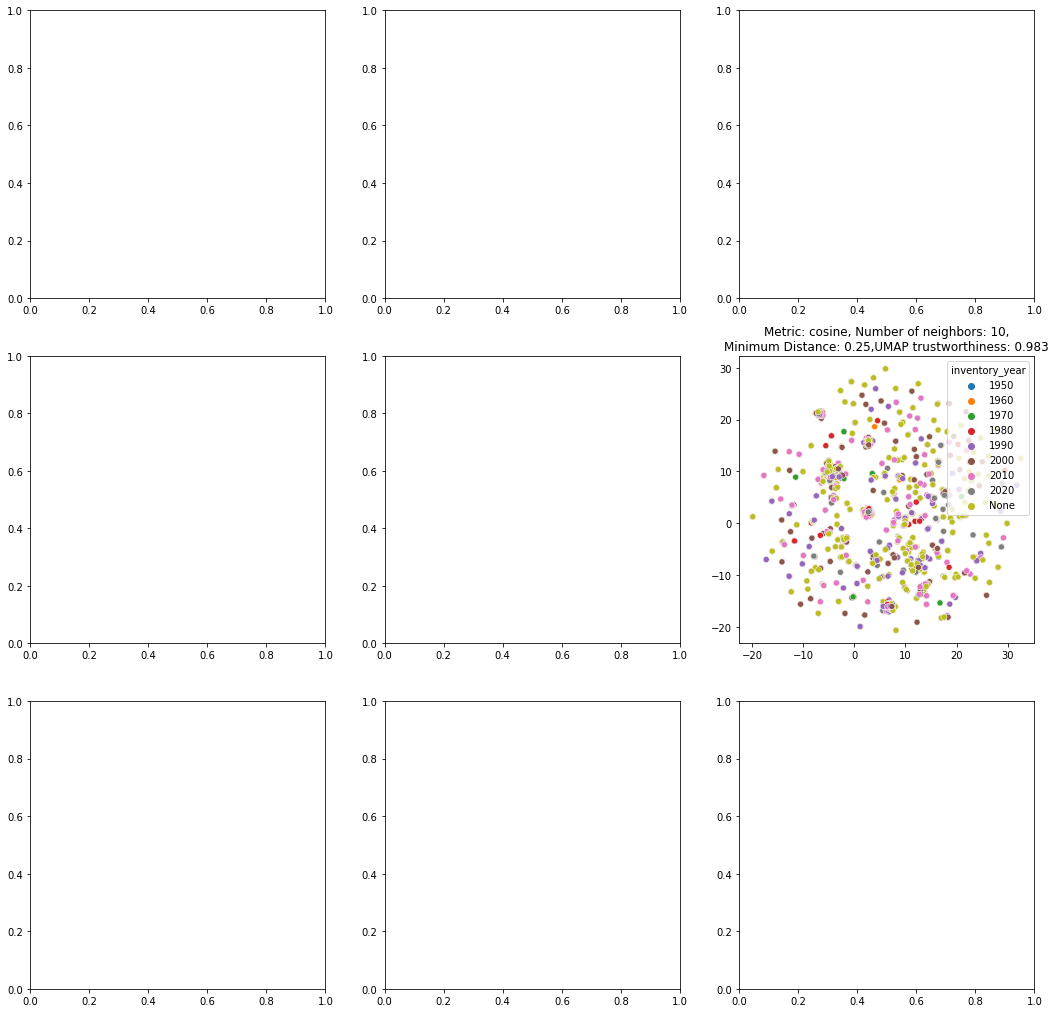

In [40]:
metrics = ['cosine', 'euclidean']
neighbors = [10, 50, 100]
min_dist = [0.1, 0.25, 0.75]

# Create a subplot grid for the scatterplots
fig, axs = plt.subplots(len(neighbors), len(min_dist), figsize=(18, 18))

umap_obj = umap.UMAP(n_components=2, n_neighbors=10, metric='cosine', min_dist=0.25, 
                        spread=1.0, random_state=42, verbose=False)
x_umap = umap_obj.fit_transform(subject_doc_matrix)
umap_tw = trustworthiness(subject_doc_matrix, x_umap, n_neighbors=10, metric='cosine')

 # Create a scatterplot of the t-SNE embeddings
order = sorted([f'{year}0' if year else 'None' for year in df.inventory_year.astype(str).str[:3].unique().tolist()])

sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df.inventory_year.astype(str).str[:3].map(lambda x:  f'{x}0' if x else 'None'), ax=axs[1, 2], hue_order=order)
axs[1, 2].set_title(f'Metric: cosine, Number of neighbors: {10},\nMinimum Distance: {0.25},UMAP trustworthiness: {umap_tw:.3f}')

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARN

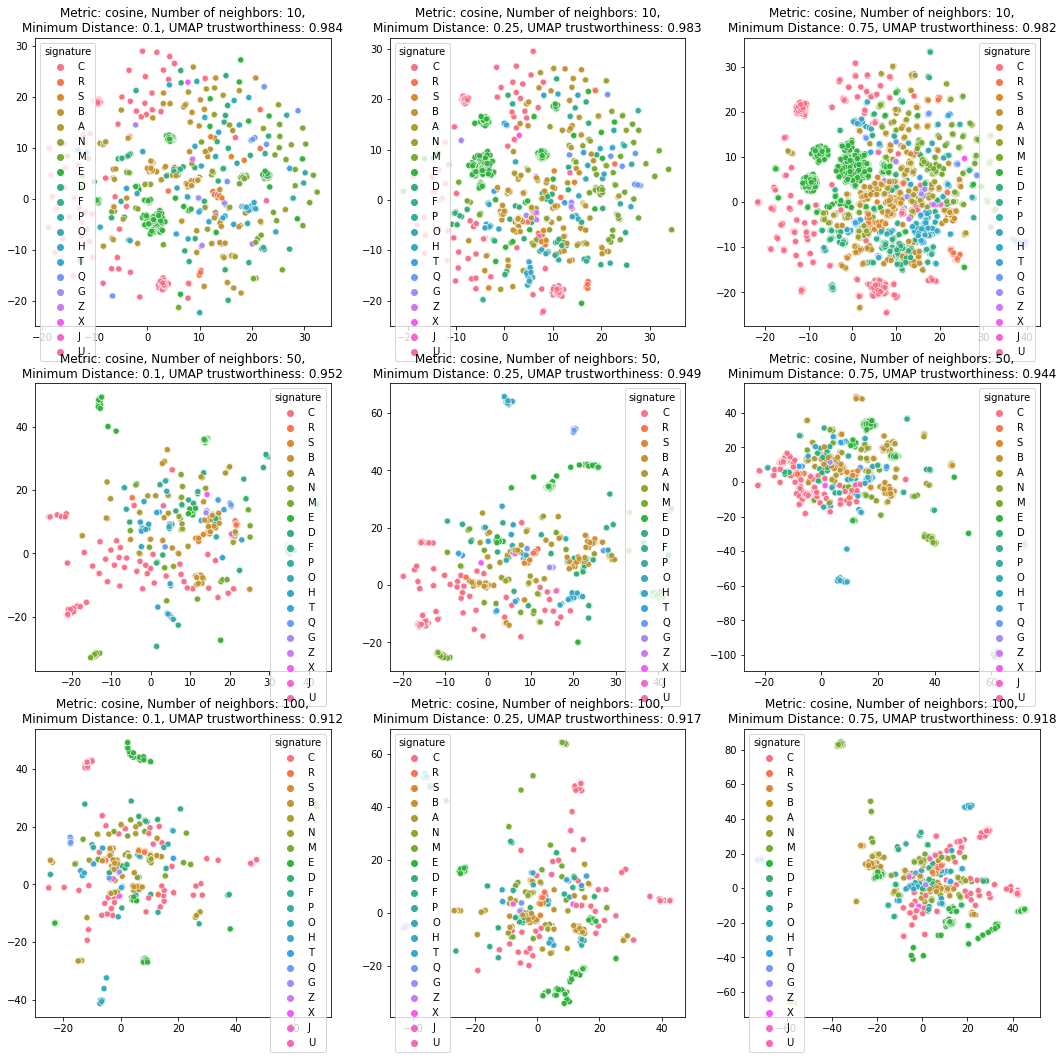

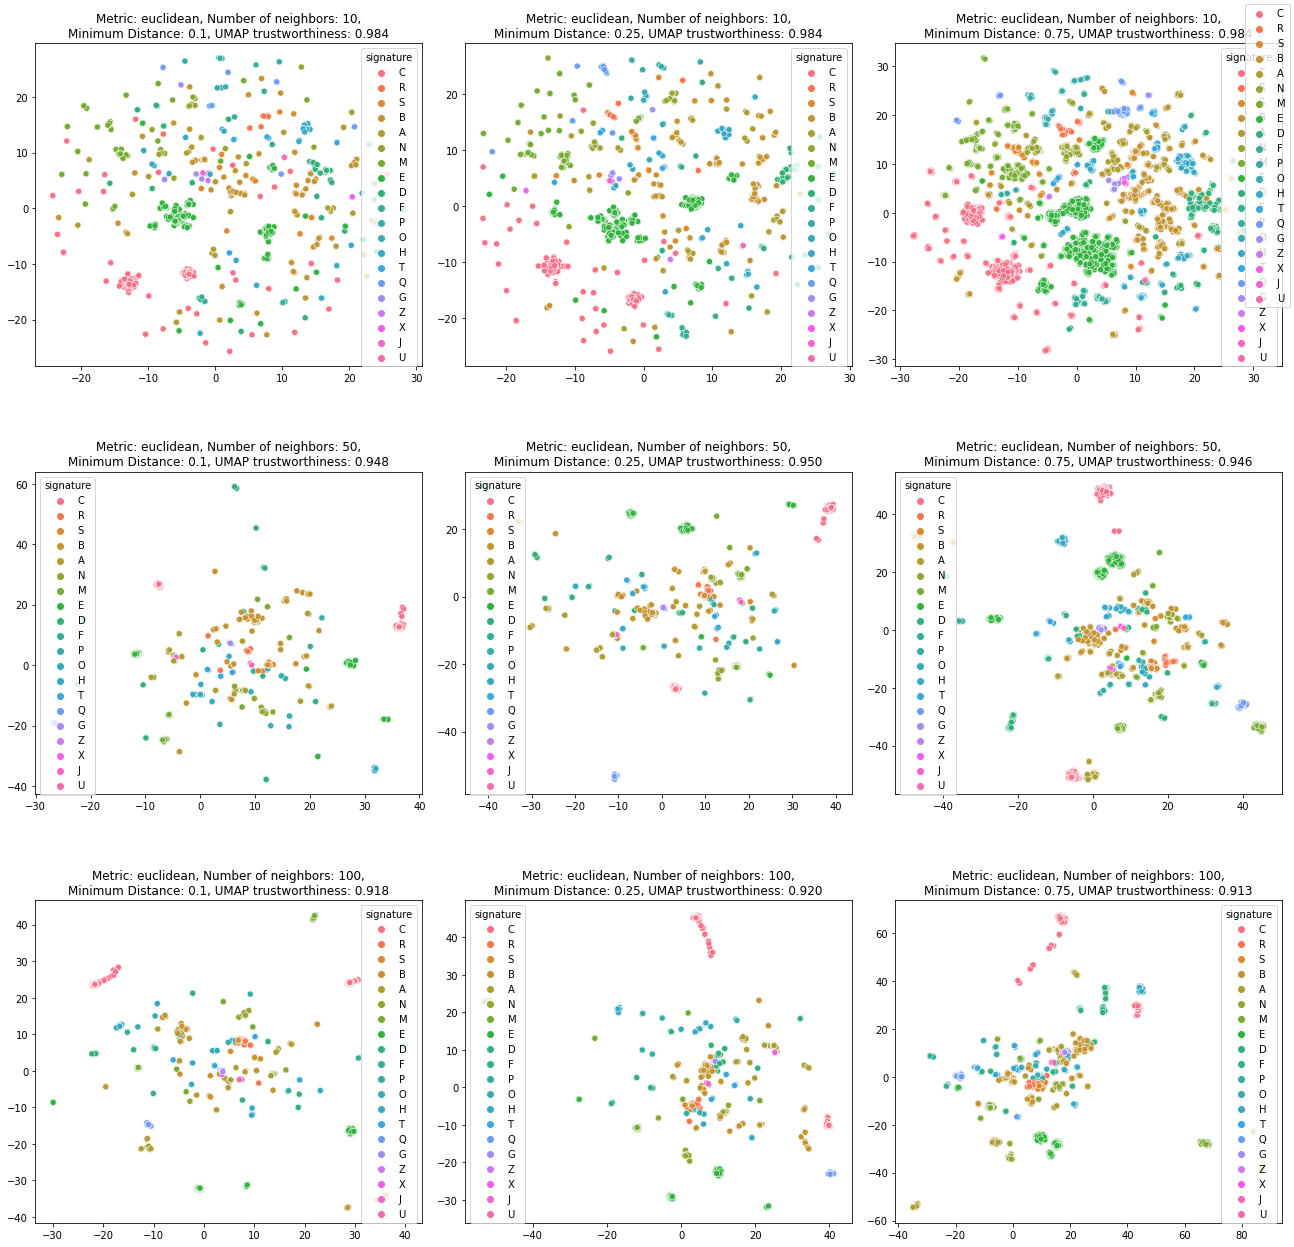

In [39]:
metrics = ['cosine', 'euclidean']
neighbors = [10, 50, 100]
min_dist = [0.1, 0.25, 0.75]

for k, metric in enumerate(metrics):

    # Create a subplot grid for the scatterplots
    fig, axs = plt.subplots(len(neighbors), len(min_dist), figsize=(18, 18))
    for i, neighbor in enumerate(neighbors):
        for j, dist in enumerate(min_dist):
            umap_obj = umap.UMAP(n_components=2, n_neighbors=neighbor, metric=metric, min_dist=dist, 
                                 spread=1.0, random_state=42, verbose=False)
            x_umap = umap_obj.fit_transform(subject_doc_matrix)
            umap_tw = trustworthiness(subject_doc_matrix, x_umap, n_neighbors=neighbor, metric=metric)

            # Create a scatterplot of the UMAP embeddings
            sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df.signature.str[0], ax=axs[i, j])
            axs[i, j].set_title(f'Metric: {metric}, Number of neighbors: {neighbor},\nMinimum Distance: {dist}, UMAP trustworthiness: {umap_tw:.3f}')

# Add a common legend for all scatterplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

# Adjust the layout of the subplots
# Adjust the spacing between subplots
plt.subplots_adjust(bottom=0.2, left=0.2)
fig.tight_layout()

# Show the scatterplots
plt.show()           

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARN

KeyboardInterrupt: 

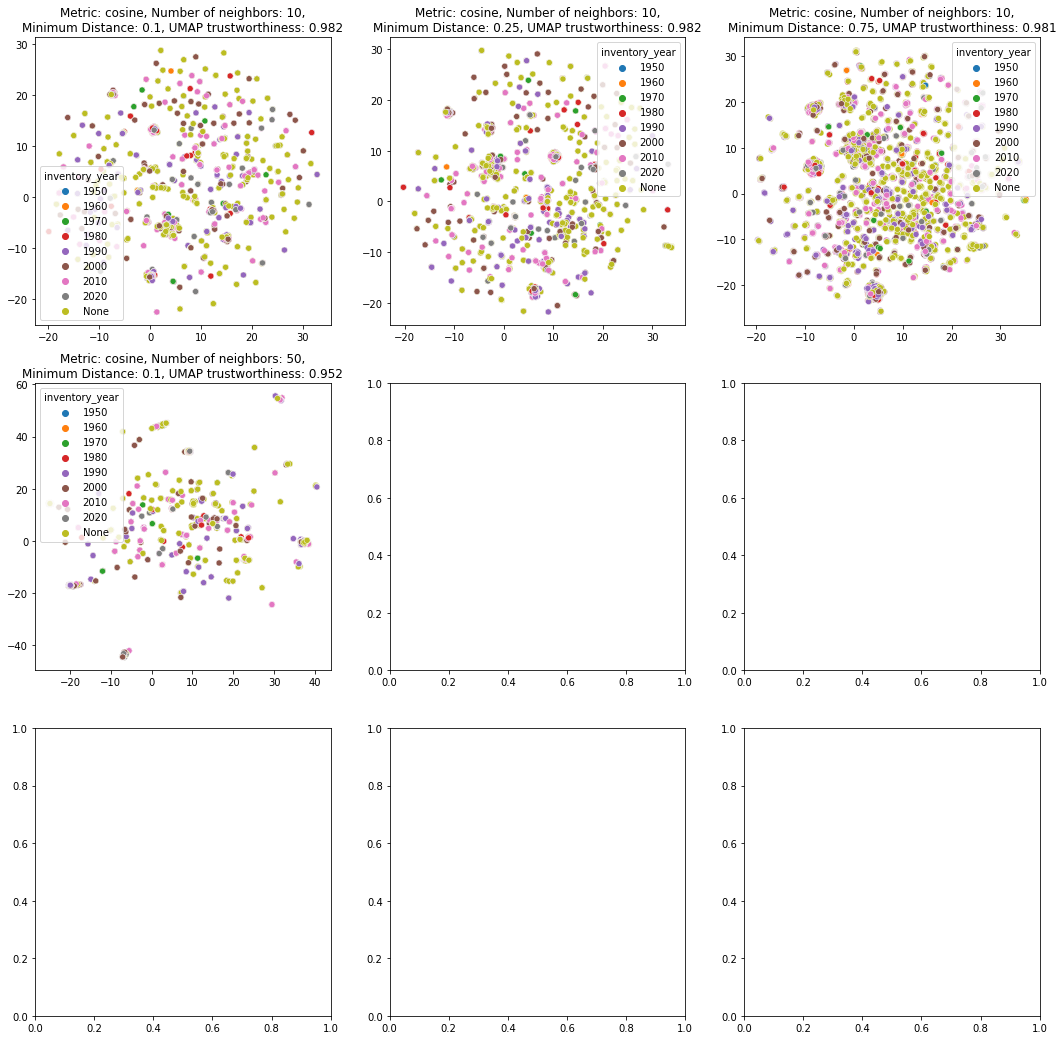

In [41]:
metrics = ['cosine', 'euclidean']
neighbors = [10, 50, 100]
min_dist = [0.1, 0.25, 0.75]

for k, metric in enumerate(metrics):

    # Create a subplot grid for the scatterplots
    fig, axs = plt.subplots(len(neighbors), len(min_dist), figsize=(18, 18))
    for i, neighbor in enumerate(neighbors):
        for j, dist in enumerate(min_dist):
            umap_obj = umap.UMAP(n_components=2, n_neighbors=neighbor, metric=metric, min_dist=dist, 
                                 spread=1.0, random_state=42, verbose=False)
            x_umap = umap_obj.fit_transform(subject_doc_matrix)
            umap_tw = trustworthiness(subject_doc_matrix, x_umap, n_neighbors=neighbor, metric=metric)

            # Create a scatterplot of the UMAP embeddings

            order = sorted([f'{year}0' if year else 'None' for year in df.inventory_year.astype(str).str[:3].unique().tolist()])
            sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df.inventory_year.astype(str).str[:3].map(lambda x:  f'{x}0' if x else 'None'), ax=axs[i, j], hue_order=order)
            axs[i, j].set_title(f'Metric: {metric}, Number of neighbors: {neighbor},\nMinimum Distance: {dist}, UMAP trustworthiness: {umap_tw:.3f}')

# Add a common legend for all scatterplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

# Adjust the layout of the subplots
# Adjust the spacing between subplots
plt.subplots_adjust(bottom=0.2, left=0.2)
fig.tight_layout()

# Show the scatterplots
plt.show()      

## t-SNE

#### Testing parameters 

In [ ]:
# Colouring based on signature

metrics= ['cosine', 'euclidean']
perplexities = [10, 30, 50]
learning_rates = [100, 200, 500]


for metric in metrics: 
    
    # Create a subplot grid for the scatterplots
    fig, axs = plt.subplots(len(perplexities), len(learning_rates), figsize=(18, 18))

    for i, perplexity in enumerate(perplexities):
        for j, learning_rate in enumerate(learning_rates):
            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric)
            x_tsne = tsne.fit_transform(subject_doc_matrix)

            tsne_tw = trustworthiness(subject_doc_matrix, x_tsne, n_neighbors=10)
            # Create a scatterplot of the t-SNE embeddings
            sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=df.signature.astype(str).str[0], ax=axs[i, j])
            axs[i, j].set_title(f'Perplexity: {perplexity}, Learning Rate: {learning_rate},\n Metric: {metric},  KL-divergence: {tsne.kl_divergence_:.3f}')

    # Add a common legend for all scatterplots
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels)

    # Adjust the layout of the subplots
    # Adjust the spacing between subplots
    plt.subplots_adjust(bottom=0.2, left=0.2)
    fig.tight_layout()

    # Show the scatterplots
    plt.show()


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0

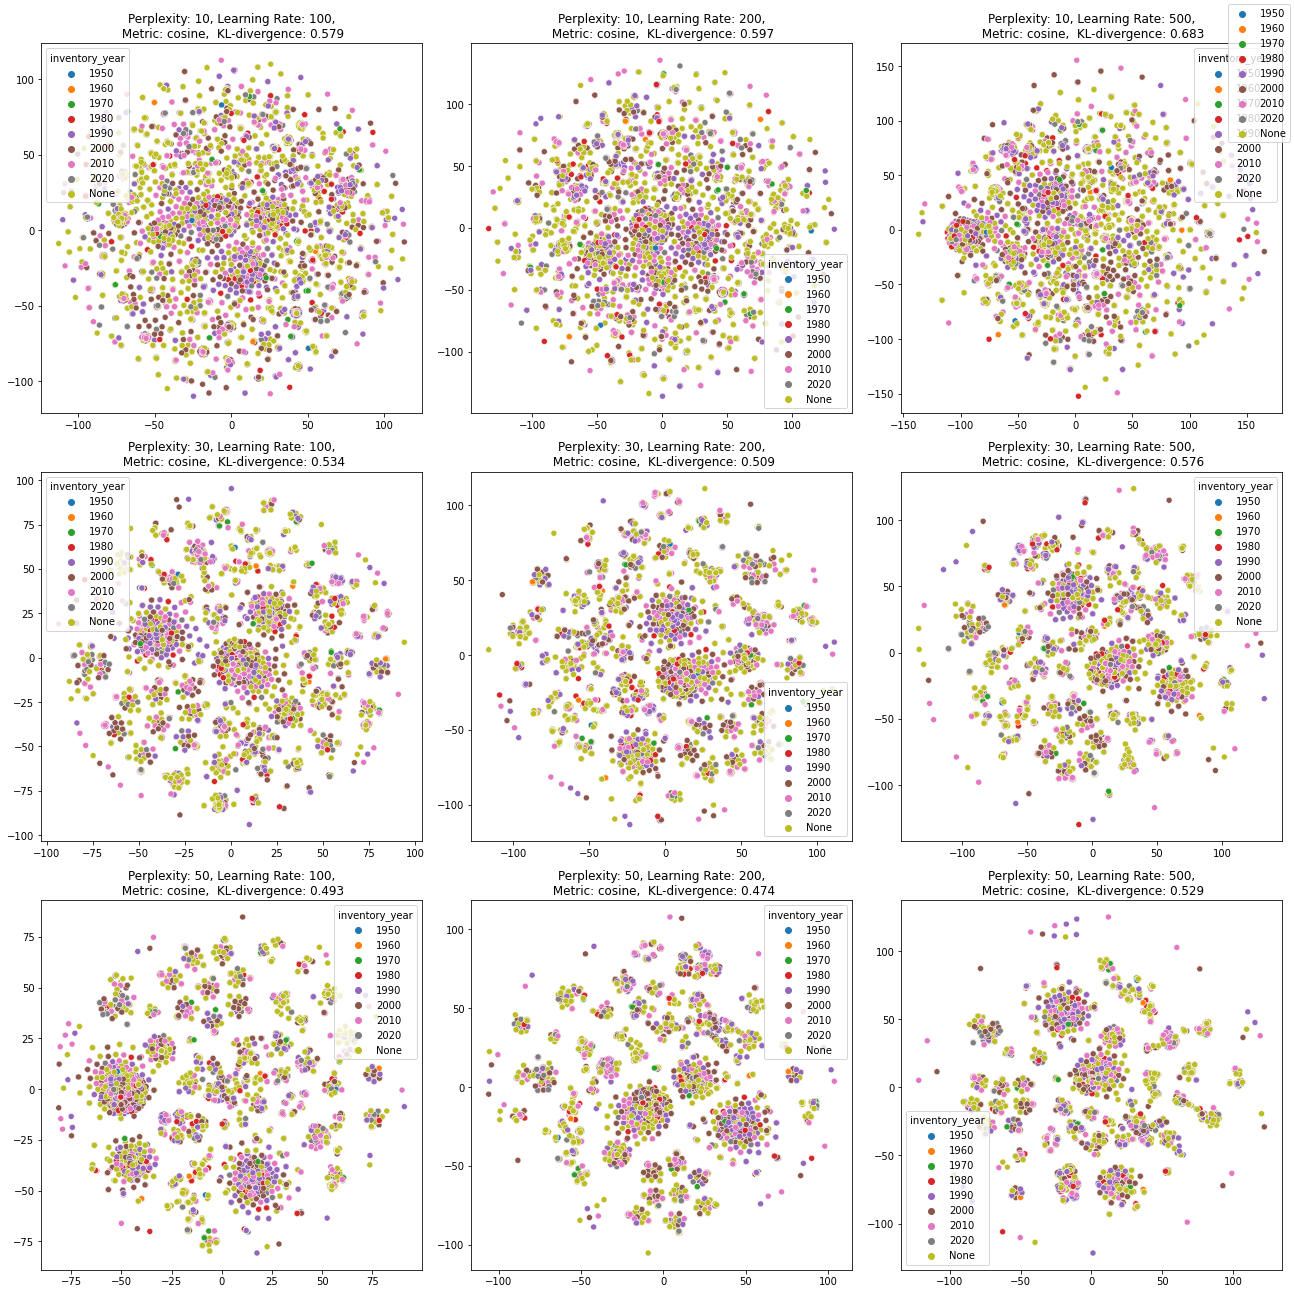

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\

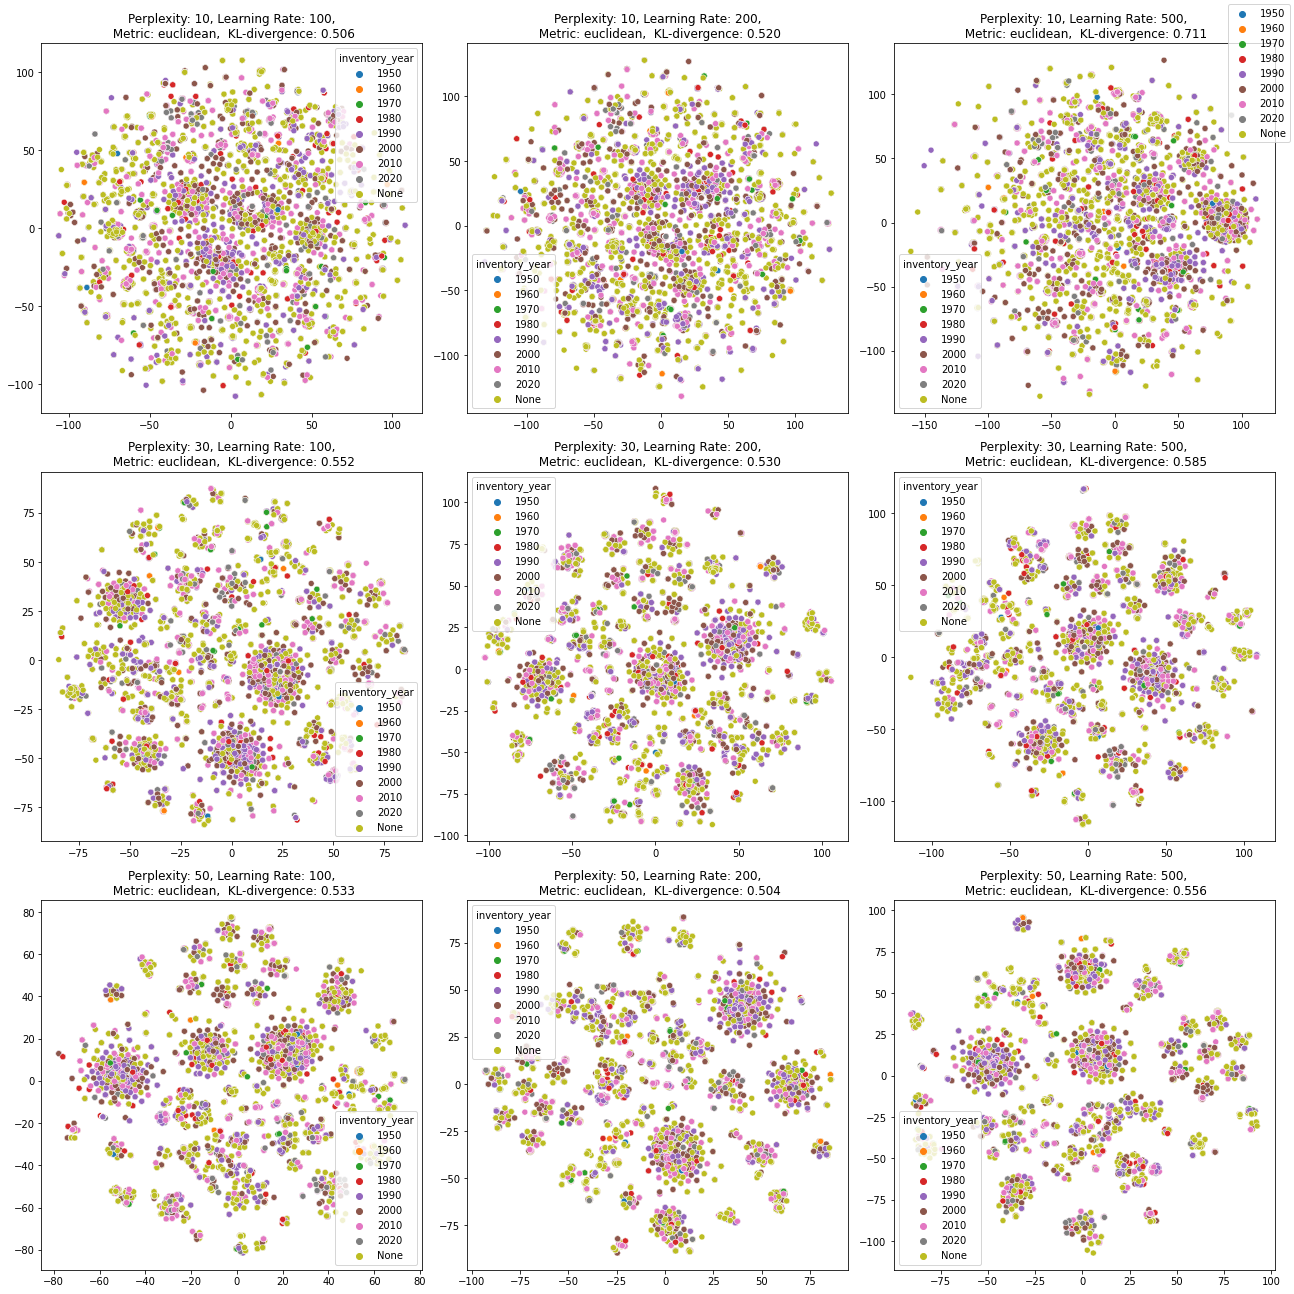

In [38]:
# Colouring based on acquisition year

metrics= ['cosine', 'euclidean']
perplexities = [10, 30, 50]
learning_rates = [100, 200, 500]


for metric in metrics: 
    
    # Create a subplot grid for the scatterplots
    fig, axs = plt.subplots(len(perplexities), len(learning_rates), figsize=(18, 18))

    for i, perplexity in enumerate(perplexities):
        for j, learning_rate in enumerate(learning_rates):
            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric)
            x_tsne = tsne.fit_transform(subject_doc_matrix)

            tsne_tw = trustworthiness(subject_doc_matrix, x_tsne, n_neighbors=10)
            # Create a scatterplot of the t-SNE embeddings
            order = sorted([f'{year}0' if year else 'None' for year in df.inventory_year.astype(str).str[:3].unique().tolist()])

            sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=df.inventory_year.astype(str).str[:3].map(lambda x:  f'{x}0' if x else 'None'), ax=axs[i, j], hue_order=order)
            axs[i, j].set_title(f'Perplexity: {perplexity}, Learning Rate: {learning_rate},\n Metric: {metric},  KL-divergence: {tsne.kl_divergence_:.3f}')

    # Add a common legend for all scatterplots
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels)

    # Adjust the layout of the subplots
    # Adjust the spacing between subplots
    plt.subplots_adjust(bottom=0.2, left=0.2)
    fig.tight_layout()

    # Show the scatterplots
    plt.show()


In [ ]:
metric = 'cosine'
perplexity = 30
learning_rate = 200

fig, ax = plt.subplots(figsize=(18, 18))

tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric)
x_tsne = tsne.fit_transform(subject_doc_matrix)

tsne_tw = trustworthiness(subject_doc_matrix, x_tsne, n_neighbors=10)
# Create a scatterplot of the t-SNE embeddings
order = sorted([f'{year}0' if year else 'None' for year in df.inventory_year.astype(str).str[:3].unique().tolist()])

sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=df.inventory_year.astype(str).str[:3].map(lambda x:  f'{x}0' if x else 'None'), ax=ax, hue_order=order)
ax.set_title(f'Perplexity: {perplexity}, Learning Rate: {learning_rate},\n Metric: {metric},  KL-divergence: {tsne.kl_divergence_:.3f}')


# Show the scatterplots
plt.show()

### Evaluation

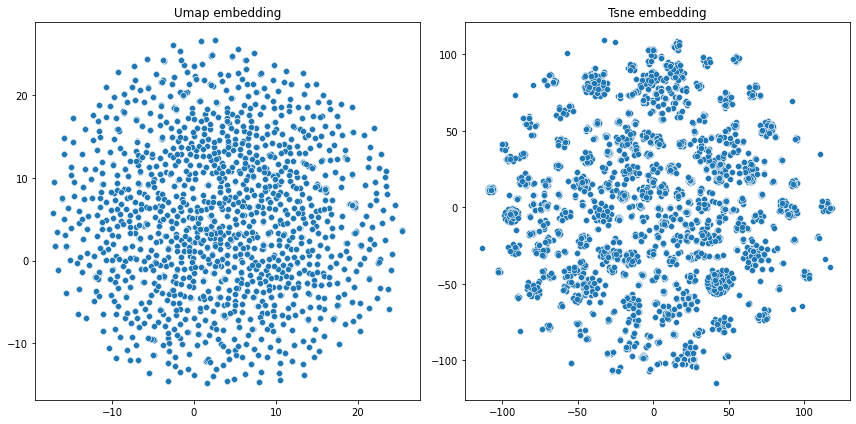

In [46]:
# Plotting

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot UMAP
sns.scatterplot(ax= axes[0], x=umap_emb[:,0], y=umap_emb[:,1], legend='full')
axes[0].set_title('Umap embedding')

# Plot tsne
sns.scatterplot(ax= axes[1], x=tsne_emb[:,0], y=tsne_emb[:,1], legend='full')
axes[1].set_title('Tsne embedding')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate trustworthiness and continuity for UMAP
umap_tw = trustworthiness(subject_doc_matrix, umap_emb, n_neighbors=10)
#umap_cn = UMAP(n_neighbors=5, min_dist=0.3).fit(subject_doc_matrix).score(subject_doc_matrix)

# Calculate trustworthiness and continuity for t-SNE
tsne_tw = trustworthiness(subject_doc_matrix, tsne_emb, n_neighbors=10)
#tsne_cn = TSNE(n_components=2, perplexity=30, learning_rate=200).fit(subject_doc_matrix).kl_divergence_

print(f"UMAP Trustworthiness: {umap_tw:.3f}")
print(f"t-SNE Trustworthiness: {tsne_tw:.3f}")


## Export the embedding

In [6]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, metric='cosine')
x_tsne = tsne.fit_transform(subject_doc_matrix)

emb = x_tsne

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


### Scale embedding

In [7]:
# Normalize 

embedding = emb * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0

embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# # Set origin at the middle

ptp = np.ptp(embedding, axis=0)  
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[ 1003,   -69],
       [ 1361,  4869],
       [ 7237,  -556],
       ...,
       [ 2508,  -695],
       [-3009,   347],
       [ 8455,  -904]])

# Cluster Identification

In [8]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

# add cluster to dataframe

df['cluster'] = clusters

#Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

# Wordclouds

In [9]:
for index, cluster in enumerate(clusters):

    # Preprocessing

    scale = 1
    
    min_X = min([i[0] for i in embedding[cluster]]) * scale
    max_X = max([i[0] for i in embedding[cluster]]) * scale
    min_Y = min([i[1] for i in embedding[cluster]]) * scale
    max_Y = max([i[1] for i in embedding[cluster]]) * scale

    width = max_X - min_X; height = max_Y - min_Y
    
    #points = list(map(lambda i: (i[0] * scale - min_X, i[1] * scale - min_Y), embedding[cluster]))
    points = [(i[0] * scale - min_X, i[1] * scale - min_Y) for i in embedding[cluster]]

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    print(width, height)
    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text.append(df.iloc[id]['subject_list'])
    text = ' '.join(text)
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')
    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word.replace('_', ' ')] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.5)
    def split_on_underscore(text):
        return text.replace('_', ' ')


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = 'Lato-Regular.ttf',
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    file_path = path.join('data/' + f"{index:02}.png")
    
    wc.to_file('../BHVizApp/src/wordclouds/'+f"{index:02}.png") # store to file

1575 1113
0 43 - 1649 905
1 16 - 788 2087
2 13 - 1074 1043
3 11 - 2437 1530
4 38 - 2651 1879
5 44 - 2007 2713
6 21 - 2006 2435
7 19 - 2005 2504
8 20 - 3511 2852
9 20 - 2938 3548
10 32 - 1791 2157
11 11 - 1433 1878
12 11 - 1791 1391
13 7 - 3296 3060
14 186 - 1433 1461
15 10 - 1433 1808
16 10 - 1433 1738
17 10 - 2293 2435
18 94 - 2220 2435
19 15 - 1362 1044
20 10 - 2221 1600
21 22 - 1361 1601
22 20 - 1505 1321
23 10 - 1648 1600
24 11 - 1218 1252
25 10 - 1505 905
26 10 - 931 905
27 24 - 3582 3548
28 276 - 1791 2157
29 26 - 1218 905
30 25 - 3439 3617
31 289 - 860 835
32 9 - 2006 1113
33 20 - 1147 1529
34 26 - 1576 1669
35 24 - 1290 1670
36 20 - 1002 1390
37 21 - 1361 1044
38 16 - 1361 765
39 14 - 

# Export

In [ ]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]

df['id'] = df.bvb

df[columns_export].to_csv(path_out, index=False)